# Import Libraries

In [26]:
import zipfile
import re
from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np
import emoji
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
from urlextract import URLExtract
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

## Data Loading

In [27]:
# defining data directory
data_dir = Path.cwd().parent/'data'
# List available whatsapp chat zip files
[i.name for i in data_dir.iterdir()]

['WhatsApp Chat with Vyasan ee veed nte nathan.zip',
 'WhatsApp Chat with Kenz.zip',
 'WhatsApp Chat with pmfa.zip']

In [29]:
# Selecting a whatsapp chat data
zip_file = data_dir/'WhatsApp Chat with pmfa.zip'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    """
    This block opens the specified ZIP file in read mode, lists its contents,
    and reads the first file (assuming it's a text file) from the archive.
    """
    # List all files in the ZIP
    print("Files in ZIP:", zip_ref.namelist())
    # Get the name of the first file in the ZIP archive
    text_file = zip_ref.namelist()[0]
    # Open and read the contents of the first file
    with zip_ref.open(text_file) as file:
        text = file.read().decode('utf-8')

Files in ZIP: ['WhatsApp Chat with pmfa.txt']


## Data Preprocessing

In [30]:
def preprocess_chat(text:str) -> pd.DataFrame:
    """
    Preprocesses raw WhatsApp chat export text and returns a cleaned DataFrame with structured data.

    Parameters:
    -----------
    text : str
        The raw text from a WhatsApp chat export file.

    Returns:
    --------
    pd.DataFrame
        A DataFrame containing structured chat data with the following columns:
        - 'date': Timestamp of the message.
        - 'user': Sender of the message.
        - 'message': Message content.
        - 'year': Year extracted from the timestamp.
        - 'month': Month extracted from the timestamp.
        - 'day': Day of the week extracted from the timestamp.
        - 'hour': Hour extracted from the timestamp.
        - 'minute': Minute extracted from the timestamp.
    """
    # Define regex pattern to extract date and time at the beginning of each message
    pattern = r'\d+/\d+/\d+,\s\d+:\d+\W*\w*\s- '
    messages = re.split(pattern,text)[1:]           # Split messages based on the pattern and discard the first empty element
    dates = re.findall(pattern,text)                # Extract all date-time strings that match the pattern

    df = pd.DataFrame({'date':dates,'content':messages})   # Create a DataFrame with extracted dates and messages
    
    df = df[df.content.str.contains(':')]            # Filter out system messages (those without a colon to indicate user-message format)
    df[['user','message']]=df['content'].str.strip().str.split(':',n=1,expand=True)
    df.message = df.message.str.strip()
    df.drop(columns='content',inplace=True)

    # Clean and convert date strings to datetime format
    df['date'] = pd.to_datetime(df.date.str.rstrip(' - '), dayfirst=True, errors='coerce' )
    df.dropna(subset=['date'], inplace=True)

    # Extract date and time components for analysis
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day_name()
    df['hour'] = df.date.dt.hour
    df['minute'] = df.date.dt.minute

    return df

In [31]:
df = preprocess_chat(text)
df.head()

,date,user,message,year,month,day,hour,minute
3,2022-01-16 19:52:00,Misab,**important info regarding online class**\n\n1...,2022,1,Sunday,19,52
4,2022-01-17 09:33:00,Thasneem,Kozhi,2022,1,Monday,9,33
5,2022-01-17 09:33:00,Thasneem,Chudande,2022,1,Monday,9,33
6,2022-01-18 17:06:00,Shahzad,null,2022,1,Tuesday,17,6
7,2022-01-18 17:06:00,Shahzad,null,2022,1,Tuesday,17,6


In [32]:
# print and show the users
users_list = df.user.unique()
print("users :",users_list)

users : ['Misab' 'Thasneem' 'Shahzad' 'Fasin' 'r a z i n Mes' 'Hamras Mes'
 'Sahal Mes' 'Thamam' 'Shabeen Abdul Varis' '+91 62355 52868' 'Kaleefa'
 '+49 1521 0295681']


## Create Stats

In [33]:
def fetch_stats(selected_user:str)->tuple :
    """
    Fetches chat statistics for a selected user or for the entire chat.

    Parameters:
    -----------
    selected_user : str | None
        Username to filter data by. If None, stats are calculated for all users.

    Returns:
    --------
    tuple[int, int, int, int, int, int]
        A tuple containing:
        - Total number of messages sent
        - Total number of words
        - Total number of media files shared
        - Total number of links shared
        - Total number of deleted messages
        - Total number of emojis used
    """

    global data, words_list, emojis_list

    # Filter the DataFrame for the selected user, or use the whole dataset
    data = df if selected_user == None else df[df['user'] == selected_user]
    total_messages_sent = data.shape[0]
    
    extractor = URLExtract()
    
    words_list, links_list, emojis_list = [], [], [] 
    media_shared, deleted_messages = 0, 0

    # Iterate through each message to compute stats
    for message in data.message:
        if message =='<Media omitted>':
            media_shared+=1
        elif message == 'This message was deleted':
            deleted_messages+=1
        else :
            # Separate out emojis and clean message
            cleaned_message = ''.join([char for char in message if not emoji.is_emoji(char)])
        
            emojis_list.extend([char for char in message if emoji.is_emoji(char)])

            # Add words (excluding emojis and links)
            words_list.extend(cleaned_message.lower().split())
            # Extract and count links
            links = extractor.find_urls(message)
            
            if links:
                links_list.extend(links)
                for link in links:
                    words_list.remove(link) 
    
    total_words = len(words_list)
    total_links = len(links_list)
    total_emojis = len(emojis_list)
    
    return total_messages_sent, total_words, media_shared, total_links, deleted_messages, total_emojis

def show_stats(selected_user:str)->None:
    """
    Displays chat statistics for a selected user or for the entire chat.

    Parameters:
    -----------
    selected_user : str | None
        Username to show stats for. If None, shows overall chat statistics.

    Returns:
    --------
    None
    """
    stats = fetch_stats(selected_user)
    print(f'User - {selected_user if selected_user else "overall"}\n'
    f'Total Messages - {stats[0]}\nTotal Words - {stats[1]}\nTotal Media Shared - {stats[2]}\nTotal Links Shared - {stats[3]}\n'
    f'Total Deleted Messages - {stats[4]}\nTotal Emojis - {stats[5]}')        

In [8]:
show_stats(None)

User - overall
Total Messages - 162
Total Words - 284
Total Media Shared - 17
Total Links Shared - 1
Total Deleted Messages - 1
Total Emojis - 12


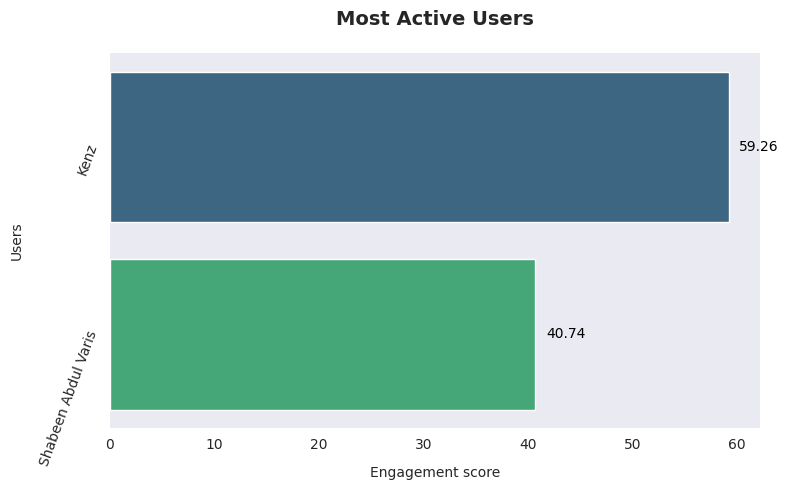

In [9]:
def show_active_users()->None:
    """
    Displays a horizontal bar chart of the most active users in the chat.

    The function calculates the percentage of messages sent by each user,
    identifies the top 6 most active users, and visualizes their engagement
    using a bar plot.

    Returns:
    --------
    None
    """
    # Calculate percentage of messages per user
    active_users = np.round((df.user.value_counts()/df.shape[0])*100,2).head(6)

    plt.figure(figsize=(8, 5))
    sns.set_style('dark')
    
    x,y = active_users.values, active_users.index
    plot = sns.barplot(x=x, y=y, palette="viridis")

    # Set plot titles and labels
    plt.title('Most Active Users', pad=20, fontsize=14, fontweight='bold')
    plt.xlabel('Engagement score', labelpad=10)
    plt.ylabel('Users', labelpad=10)
    plt.yticks(rotation=70)

    # Annotate bars with percentage values
    for i, v in enumerate(x):
        plot.text(v + 1, i, str(v), color='black', va='center')

    # Clean up plot appearance
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

show_active_users()

### Remove stop words

In [22]:
# Download stopwords if not already downloaded
nltk.download('stopwords')

def remove_stopwords(words: list[str]) -> list[str]:
    """
    Removes common English stopwords from a list of words.

    Parameters:
    -----------
    words : list[str]
        The list of words to filter.

    Returns:
    --------
    list[str]
        Filtered list without stopwords.
    """
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

# Apply to global words_list
words_list = remove_stopwords(words_list)

[nltk_data] Downloading package stopwords to /home/kudsit/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


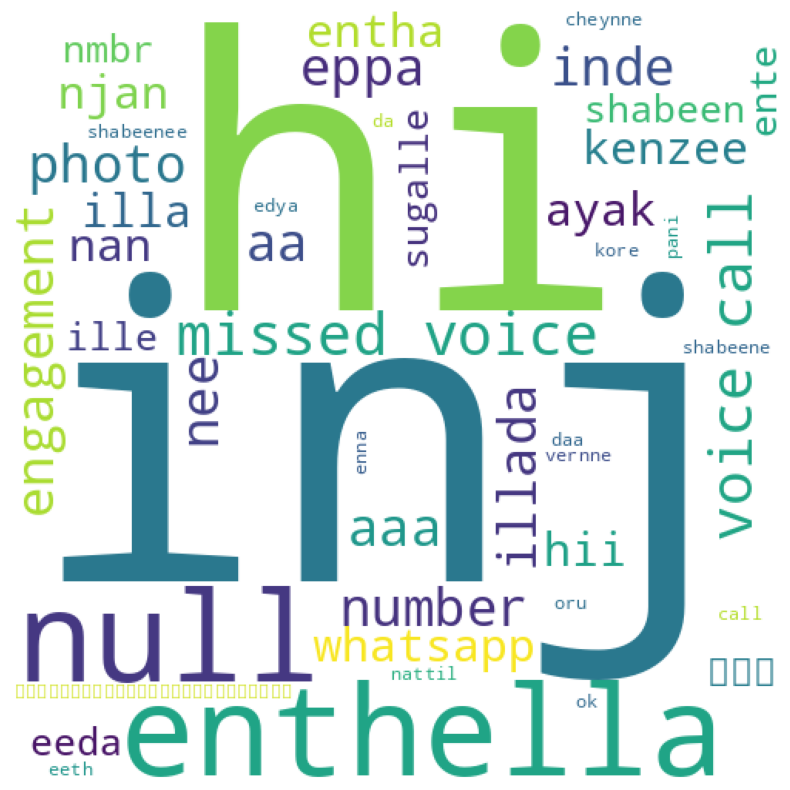

In [24]:
def create_wordcloud()->None:
    """
    Generates and displays a word cloud from the global `words_list`.

    The function uses the WordCloud library to visualize the most frequent words
    from the list `words_list`, which should contain cleaned and tokenized words
    from chat messages.

    Returns:
    --------
    None
    """
    # Create a WordCloud object with specified dimensions and settings
    wc_fig = WordCloud(width=500,height=500,min_font_size=10,background_color='white',max_words=100)
    wc_fig.generate(' '.join(words_list))
    # Display the word cloud using matplotlib
    fig = plt.figure(figsize=(14,10))
    plt.imshow(wc_fig) 
    plt.axis('off')

create_wordcloud()

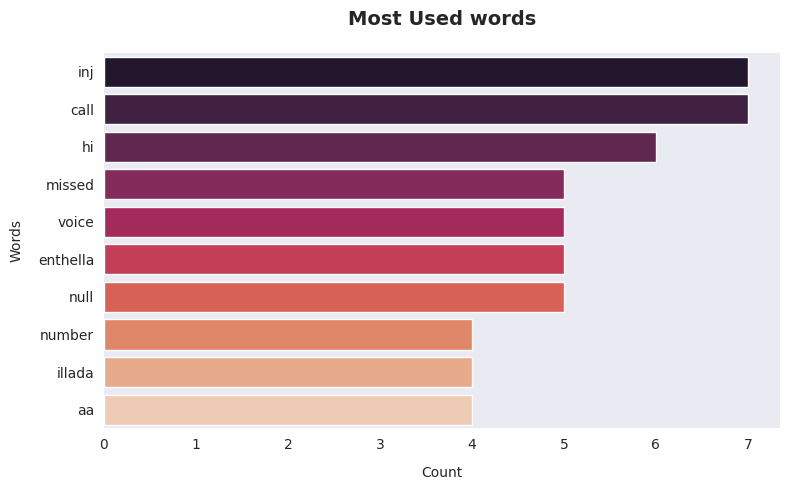

In [25]:
def get_most_common_words(n=10):
    """
    Plots a bar chart of the most common words in the global `words_list`.

    Parameters:
    -----------
    n : int, optional (default=10)
        The number of top words to display in the chart.

    Returns:
    --------
    None
    """
    # Count the n most common words in the list
    most_common_words = pd.DataFrame(Counter(words_list).most_common(n))
    
    plt.figure(figsize=(8, 5))
    sns.set_style('dark')
    
    plot = sns.barplot(data=most_common_words, x=1, y=0, palette="rocket") # Create the bar plot
    # Customize the plot
    plt.title('Most Used words', pad=20, fontsize=14, fontweight='bold')
    plt.xlabel('Count', labelpad=10)
    plt.ylabel('Words', labelpad=10)
    # Improve layout and appearance
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()    

get_most_common_words()

In [12]:
def get_most_used_emoji():
    """
    Returns a DataFrame of the top 10 most frequently used emojis 
    from the global `emojis_list`.

    Returns:
    --------
    pd.DataFrame
        A DataFrame with two columns:
        - 'emoji': The emoji character
        - 'count': Number of times the emoji was used
    """
    emoji_df = pd.DataFrame(Counter(emojis_list).most_common(10),columns=['emoji','count'])
    return emoji_df
    
get_most_used_emoji()

,emoji,count
0,🌙,2
1,👍,2
2,🏻,2
3,😀,1
4,🙄,1
5,😨,1
6,🥱,1
7,✨,1
8,😆,1


## Timeline and Activity

### Year wise

In [13]:
year_stat = data.groupby(['year','month']).message.count().reset_index()
year_stat.month = year_stat.month.map({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July',\
                     8:'August',9:'September',10:'october',11:'November',12:'December'})
year_stat['index'] = year_stat['month']+'-'+year_stat['year'].astype(str)
year_stat.set_index('index',inplace=True)

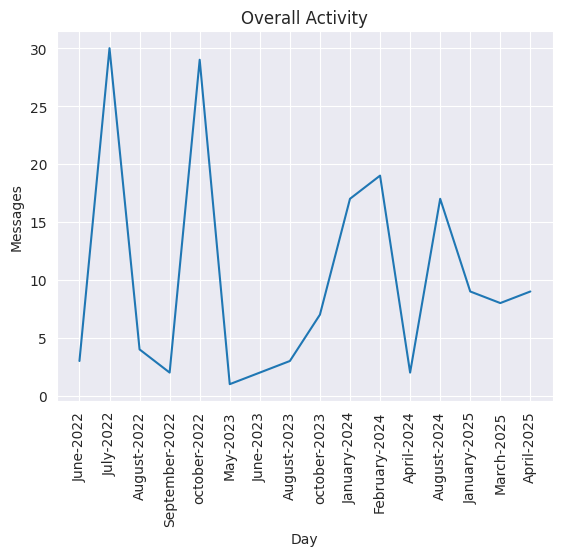

In [14]:
fig,ax = plt.subplots()
sns.lineplot(data = year_stat, y='message', x='index', markers='o', dashes=False)

plt.title('Overall Activity')
plt.xlabel('Day')
plt.xticks(rotation=90)
plt.ylabel('Messages')
plt.grid(True)
plt.show()

### Date wise

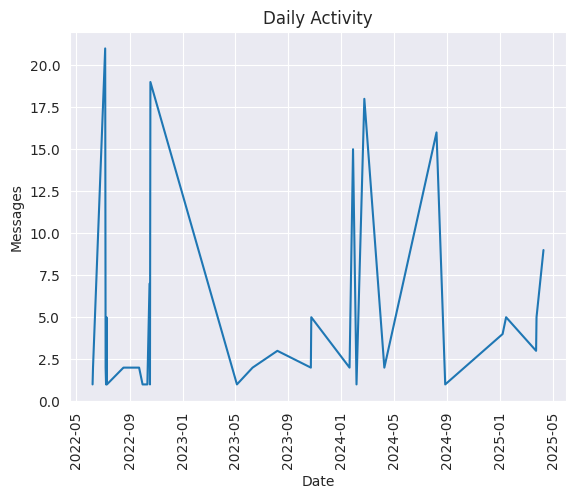

In [15]:
date_stat = data.groupby(data.date.dt.date).message.count()
sns.lineplot(date_stat)

plt.title('Daily Activity')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Messages')
plt.grid(True)
plt.show()

### weekday wise

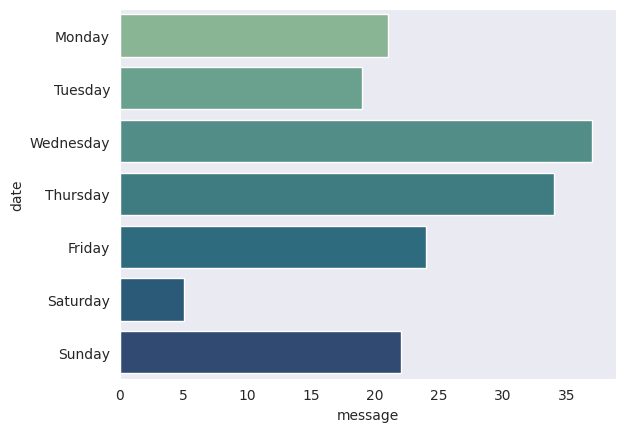

In [16]:
week_stat = data.groupby(data.date.dt.weekday).message.count().sort_index()
week_stat.index = week_stat.index.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
sns.barplot(data = week_stat.reset_index(), x='message', y='date', palette='crest');

### Month wise

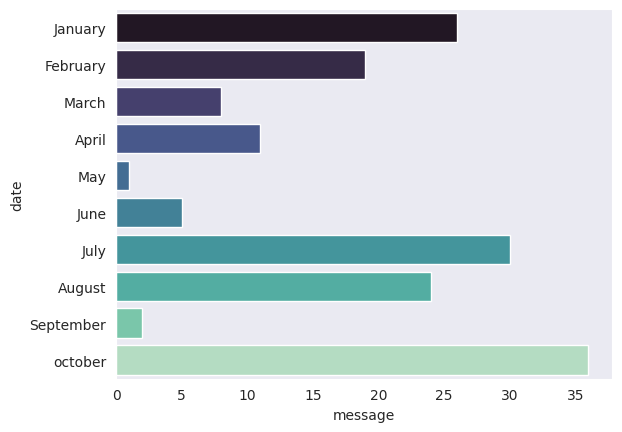

In [17]:
month_stat = data.groupby(data.date.dt.month).message.count().sort_index()
month_stat.index = month_stat.index.map({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July',\
                     8:'August',9:'September',10:'october',11:'November',12:'December'})
sns.barplot(data = month_stat.reset_index(), x='message', y='date', palette='mako');

### Hour wise

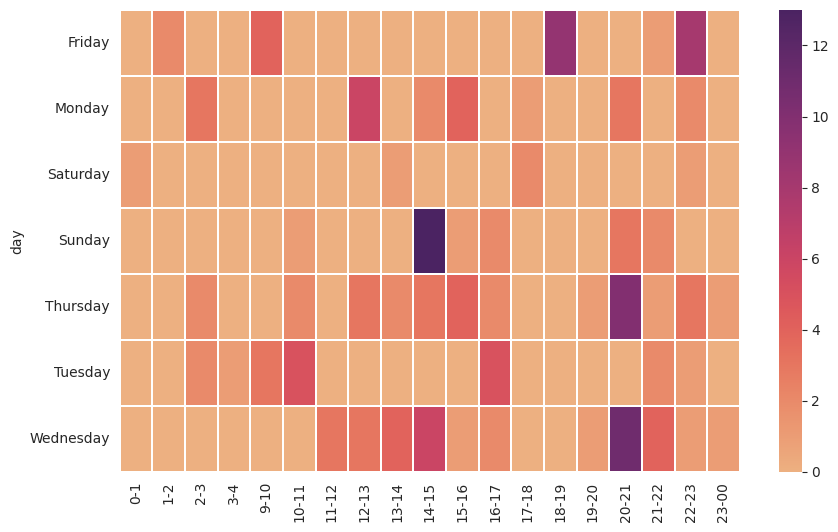

In [18]:
hour_stat = pd.pivot_table(data=data,columns='hour',index='day',values='message',aggfunc= 'count',fill_value=0)
new_time = [str(i)+'-'+'00'  if i==23 else str(i)+'-'+str(i+1) for i in hour_stat.columns]
hour_stat.columns = new_time

plt.figure(figsize=(10, 6))
sns.heatmap(hour_stat,cmap='flare',linewidths=.1);

-----
